In [ ]:
import numpy as np
import torch as tc
import matplotlib.pyplot as plt
import torchvision as tv
import os
!pip install SimpleITK
import SimpleITK as sitk

download = True # Set to True only during the first run or after resetting the notebook, then set to False
train = False # Let's use the testing dataset
root = '/content/MNIST' # Let's download the dataset to the /content folder
transform = tv.transforms.ToTensor() # Used to convert the PIL image to PyTorch Tensor

# Create the MNIST dataset
mnist_dataset = tv.datasets.MNIST(root=root, train=train, download=download, transform=transform)

print(f"Testing MNIST dataset length: {len(mnist_dataset)}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 11.6 MB/s eta 0:00:00
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17959417.92it/s]


Extracting /content/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 487163.72it/s]


Extracting /content/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4473927.70it/s]


Extracting /content/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5242302.91it/s]

Extracting /content/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/MNIST/raw

Testing MNIST dataset length: 10000


In [ ]:
batch_size = 16  # The number of cases to be loaded at once
shuffle = False  # Whether to load the dataset in random order
num_workers = 2  # The number of CPU cores used by the DataLoader

# Create the DataLoader object
mnist_dataloader = tc.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

# Let's print the length of the dataloader
print(f"Length of MNIST DataLoader: {len(mnist_dataloader)}")


Length of MNIST DataLoader: 625


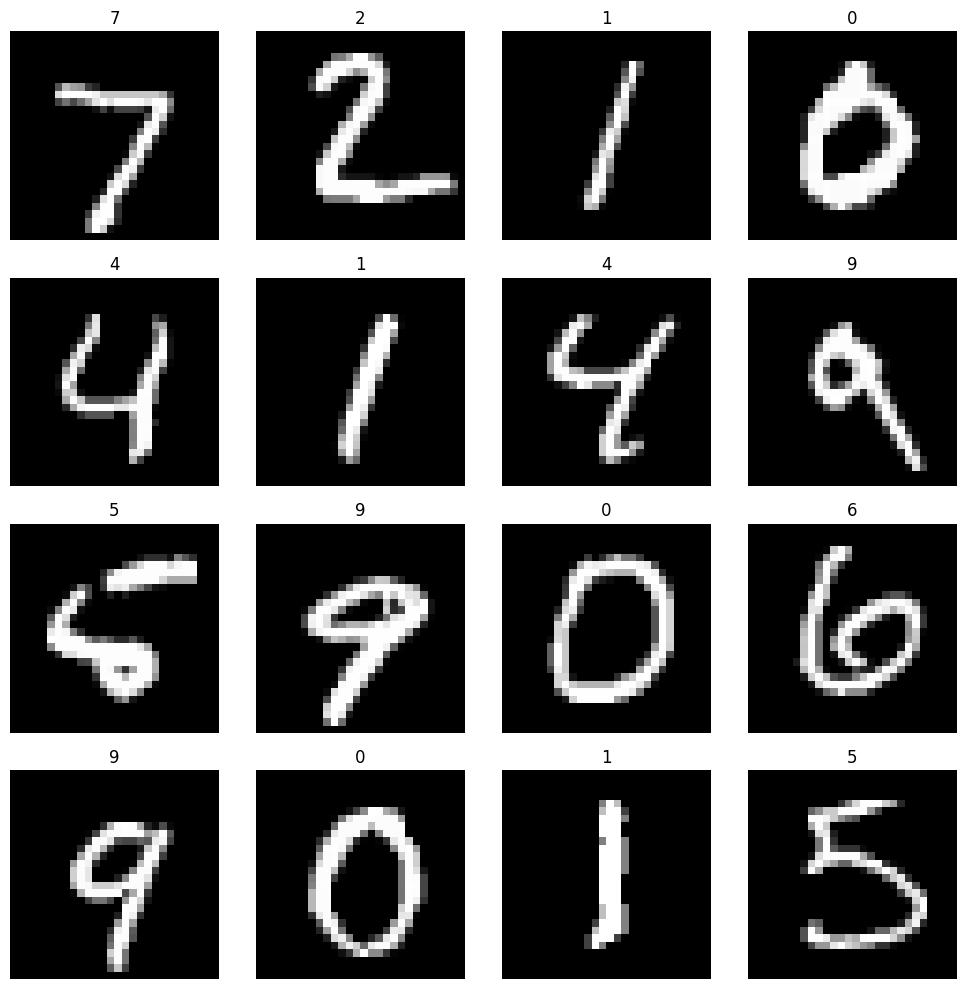

In [ ]:
for images, classes in mnist_dataloader:
    fig, axs = plt.subplots(4, 4, figsize=(10, 10))
    for i in range(16):
        ax = axs[i // 4, i % 4]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f"{classes[i]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    break



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
input_file =  '/content/drive/MyDrive/ColabNotebooks/Lab_3/Brain_MRI.zip'
output_folder = '/content/drive/MyDrive/ColabNotebooks/Lab_3/'

print(f"Input file path: {input_file}")
print(f"Output folder path: {output_folder}")

# !unzip {input_file} -d {output_folder} # Do this only once, them comment out this command

Input file path: /content/drive/MyDrive/ColabNotebooks/Lab_3/Brain_MRI.zip
Output folder path: /content/drive/MyDrive/ColabNotebooks/Lab_3/


In [ ]:
import os
import torch as tc
import torchvision.transforms as transforms
from PIL import Image

class BrainMRIDataset(tc.utils.data.Dataset):
    def __init__(self, dataset_path: str, mode: str = "training"):
        self.dataset_path = dataset_path
        self.mode = mode  # "training" or "testing"

        if self.mode == "training":
            self.data_path = os.path.join(self.dataset_path, "Training")
        elif self.mode == "testing":
            self.data_path = os.path.join(self.dataset_path, "Testing")
        else:
            raise ValueError("Unsupported mode.")

        self.classes = os.listdir(self.data_path)
        print(f"Available classes: {self.classes}")
        self.classes_dict = {self.classes[i]: i for i in range(len(self.classes))}
        print(f"Classes dict: {self.classes_dict}")

        self.cases = []
        for current_class in self.classes:
            class_path = os.path.join(self.data_path, current_class)
            for current_case in os.listdir(class_path):
                case_path = os.path.join(class_path, current_case)
                self.cases.append((case_path, self.classes_dict[current_class]))

    def __len__(self):
        return len(self.cases)

    def __getitem__(self, idx):
        current_case = self.cases[idx]
        current_path = current_case[0]
        current_class = current_case[1]
        current_image = Image.open(current_path).convert('L')

        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        current_image = transform(current_image)

        return current_image, current_class



Available classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Classes dict: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


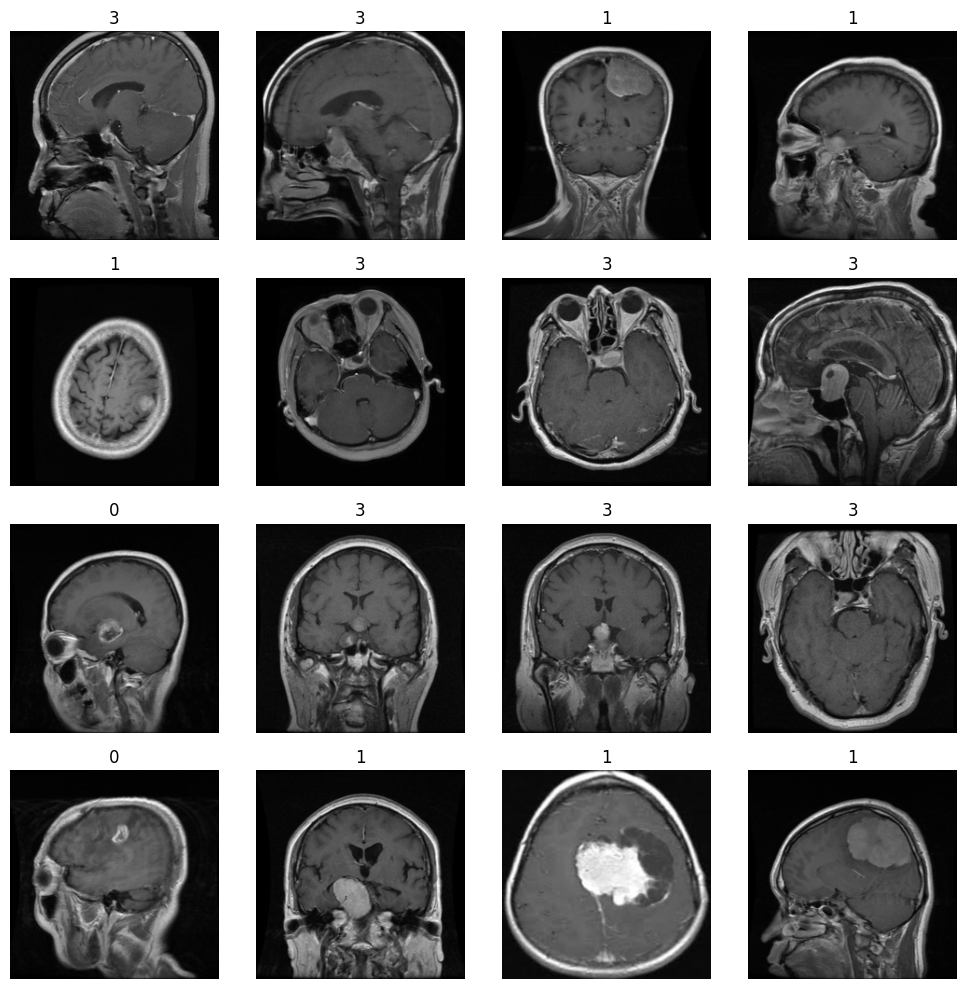

In [ ]:
import torch as tc
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


mri_dataset = BrainMRIDataset(dataset_path='/content/drive/MyDrive/ColabNotebooks/Lab_3/', mode="training")

batch_size = 16
shuffle = True

mri_dataloader = DataLoader(mri_dataset, batch_size=batch_size, shuffle=shuffle)

for images, labels in mri_dataloader:
    images = images.numpy().transpose((0, 2, 3, 1)).squeeze()

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
        ax.set_title(labels[i].item())
    plt.tight_layout()
    plt.show()

    break


In [ ]:
import os
import pandas as pd

dataset_path = '/content/drive/MyDrive/ColabNotebooks/Lab_3/'
training_csv_path = os.path.join(dataset_path, "training.csv")
testing_csv_path = os.path.join(dataset_path, "testing.csv")

training_data_path = os.path.join(dataset_path, "Training")
testing_data_path = os.path.join(dataset_path, "Testing")

classes = os.listdir(training_data_path)
print(f"Available classes: {classes}")

classes_dict = {classes[i]: i for i in range(len(classes))}
print(f"Classes dict: {classes_dict}")

training_cases = []
testing_cases = []

for current_class in classes:
    class_number = classes_dict[current_class]
    class_path = os.path.join(training_data_path, current_class)
    for case in os.listdir(class_path):
        case_path = os.path.join(class_path, case)
        training_cases.append((case_path, class_number, current_class))

for current_class in classes:
    class_number = classes_dict[current_class]
    class_path = os.path.join(testing_data_path, current_class)
    for case in os.listdir(class_path):
        case_path = os.path.join(class_path, case)
        testing_cases.append((case_path, class_number, current_class))

training_df = pd.DataFrame(training_cases, columns=['image_path', 'image_class_number', 'image_class_name'])
testing_df = pd.DataFrame(testing_cases, columns=['image_path', 'image_class_number', 'image_class_name'])

training_df.to_csv(training_csv_path, index=False)
testing_df.to_csv(testing_csv_path, index=False)



Available classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Classes dict: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


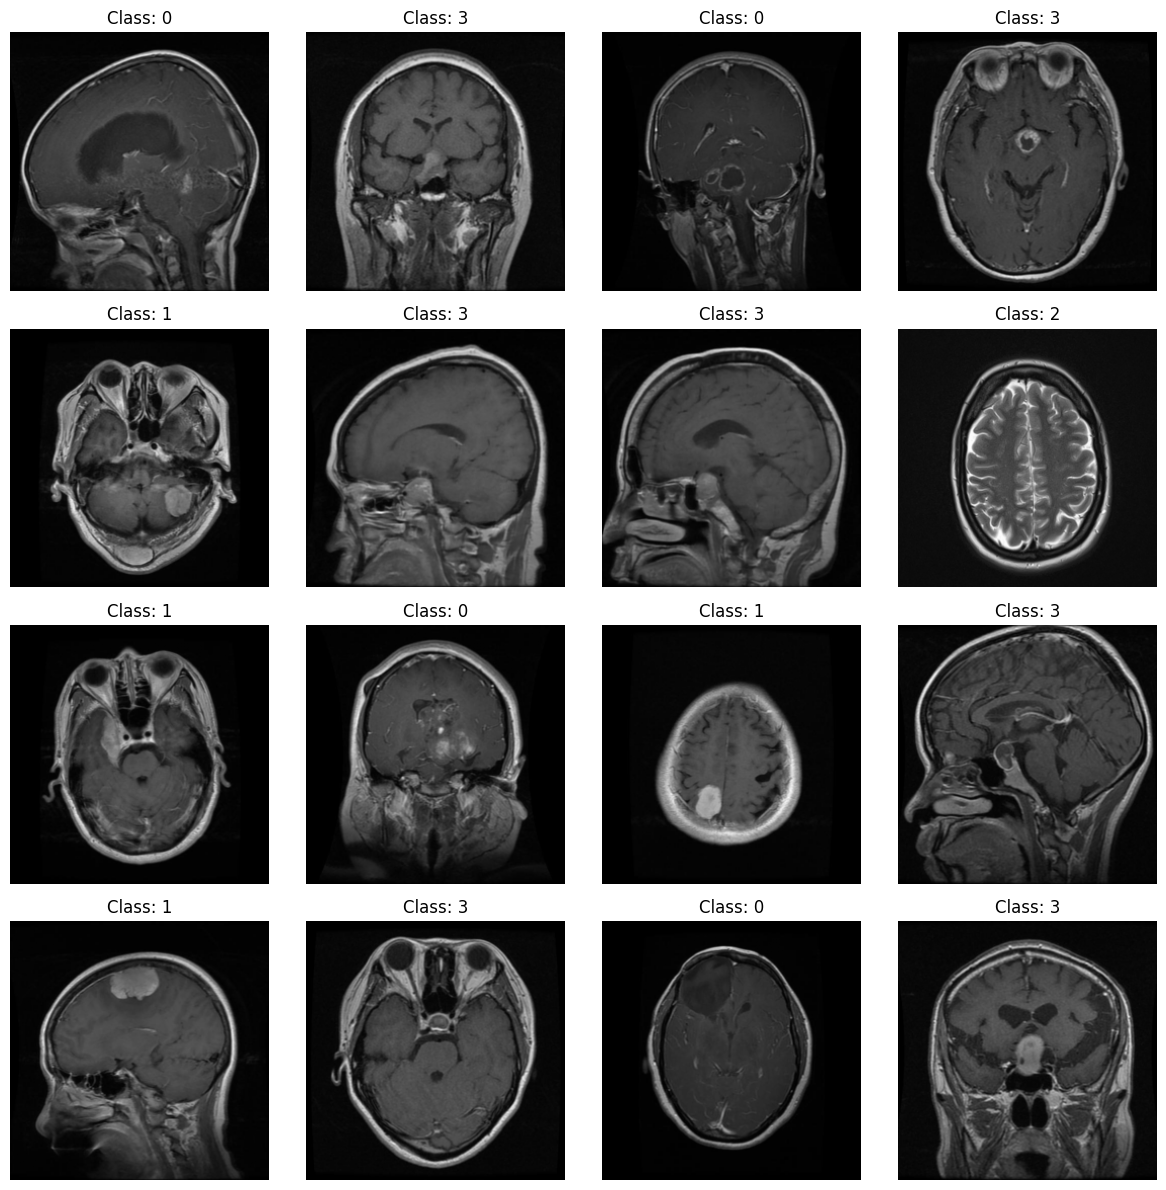

In [ ]:
import os
import pandas as pd
import torch as tc
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt

class BrainDataset(Dataset):
    def __init__(self, dataset_path, csv_path, transforms=None, z_norm=False):
        self.dataset_path = dataset_path
        self.csv_path = csv_path
        self.transforms = transforms
        self.z_norm = z_norm
        self.dataframe = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.dataset_path, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.dataframe.iloc[idx, 1]

        if self.transforms:
            image = self.transforms(image)

        if self.z_norm:
            image = (image - image.mean()) / image.std()

        return image, label

batch_size = 16
shuffle = True

transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

training_dataset = BrainDataset(os.path.join(dataset_path, "Training"), training_csv_path, transforms=transform)
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)

for images, classes in training_dataloader:
    fig, axs = plt.subplots(4, 4, figsize=(12, 12))
    for i in range(batch_size):
        row = i // 4
        col = i % 4
        img = images[i].permute(1, 2, 0).numpy()
        axs[row, col].imshow(img)
        axs[row, col].set_title(f'Class: {classes[i]}')
        axs[row, col].axis('off')
    plt.tight_layout()
    plt.show()
    break


In [ ]:
input_file_1 = '/content/drive/MyDrive/ColabNotebooks/Lab_3/Instruments_Endoscopy.zip'
output_folder_1 = '/content/drive/MyDrive/ColabNotebooks/Lab_3/'

print(f"Input file path: {input_file_1}")
print(f"Output folder path: {output_folder_1}")

!unzip {input_file_1} -d {output_folder_1} # Do this only once, them comment out this command

Input file path: /content/drive/MyDrive/ColabNotebooks/Lab_3/Instruments_Endoscopy.zip
Output folder path: /content/drive/MyDrive/ColabNotebooks/Lab_3/
Archive:  /content/drive/MyDrive/ColabNotebooks/Lab_3/Instruments_Endoscopy.zip
  inflating: /content/drive/MyDrive/ColabNotebooks/Lab_3/kvasir-instrument/bboxes.json  
  inflating: /content/drive/MyDrive/ColabNotebooks/Lab_3/kvasir-instrument/images/images/ckcu8ty6z00003b5yzfaezbs5.jpg  
  inflating: /content/drive/MyDrive/ColabNotebooks/Lab_3/kvasir-instrument/images/images/ckcu8v7pr00013b5ymfi2z7uf.jpg  
  inflating: /content/drive/MyDrive/ColabNotebooks/Lab_3/kvasir-instrument/images/images/ckcu8w7vy00023b5y3vt2wczx.jpg  
  inflating: /content/drive/MyDrive/ColabNotebooks/Lab_3/kvasir-instrument/images/images/ckcu8xad600033b5yc78xfyjx.jpg  
  inflating: /content/drive/MyDrive/ColabNotebooks/Lab_3/kvasir-instrument/images/images/ckcu99qx200043b5yd2c5g84t.jpg  
  inflating: /content/drive/MyDrive/ColabNotebooks/Lab_3/kvasir-instrument

In [ ]:
import pandas as pd
import scipy.ndimage
from skimage import color

data_path = os.path.join(output_folder_1, "kvasir-instrument")
path_to_images = os.path.join(data_path, "images/images")
path_to_masks = os.path.join(data_path, "masks/masks")
matched_cvs_path = os.path.join(data_path, "mathced.csv")
images_cases = os.listdir(path_to_images)

matched_cases = []

for image in images_cases:
  image_path = os.path.join(path_to_images, image)
  mask_path = os.path.join(path_to_masks, image.replace("jpg", "png"))
  matched_cases.append([image_path, mask_path])

dataframe = pd.DataFrame(matched_cases, columns = ["image_Path", "Mask_Path"])
print(dataframe.head())
dataframe.to_csv(matched_cvs_path, index=False)


                                          image_Path  \
0  /content/drive/MyDrive/ColabNotebooks/Lab_3/kv...   
1  /content/drive/MyDrive/ColabNotebooks/Lab_3/kv...   
2  /content/drive/MyDrive/ColabNotebooks/Lab_3/kv...   
3  /content/drive/MyDrive/ColabNotebooks/Lab_3/kv...   
4  /content/drive/MyDrive/ColabNotebooks/Lab_3/kv...   

                                           Mask_Path  
0  /content/drive/MyDrive/ColabNotebooks/Lab_3/kv...  
1  /content/drive/MyDrive/ColabNotebooks/Lab_3/kv...  
2  /content/drive/MyDrive/ColabNotebooks/Lab_3/kv...  
3  /content/drive/MyDrive/ColabNotebooks/Lab_3/kv...  
4  /content/drive/MyDrive/ColabNotebooks/Lab_3/kv...  


In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


class EndoscopyDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.data.iloc[idx, 0]
        mask_name = self.data.iloc[idx, 1]

        image = Image.open(img_name).convert("RGB")
        mask = Image.open(mask_name).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

csv_file_path = os.path.join(output_folder_1, "kvasir-instrument/mathced.csv")
endoscopy_dataset = EndoscopyDataset(csv_file=csv_file_path, transform=transform)

print(f"Dataset size: {len(endoscopy_dataset)}")

dataloader = DataLoader(endoscopy_dataset, batch_size=4, shuffle=True, num_workers=4)

for images, masks in dataloader:
    print(images.shape, masks.shape)
    break



Dataset size: 590


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256])


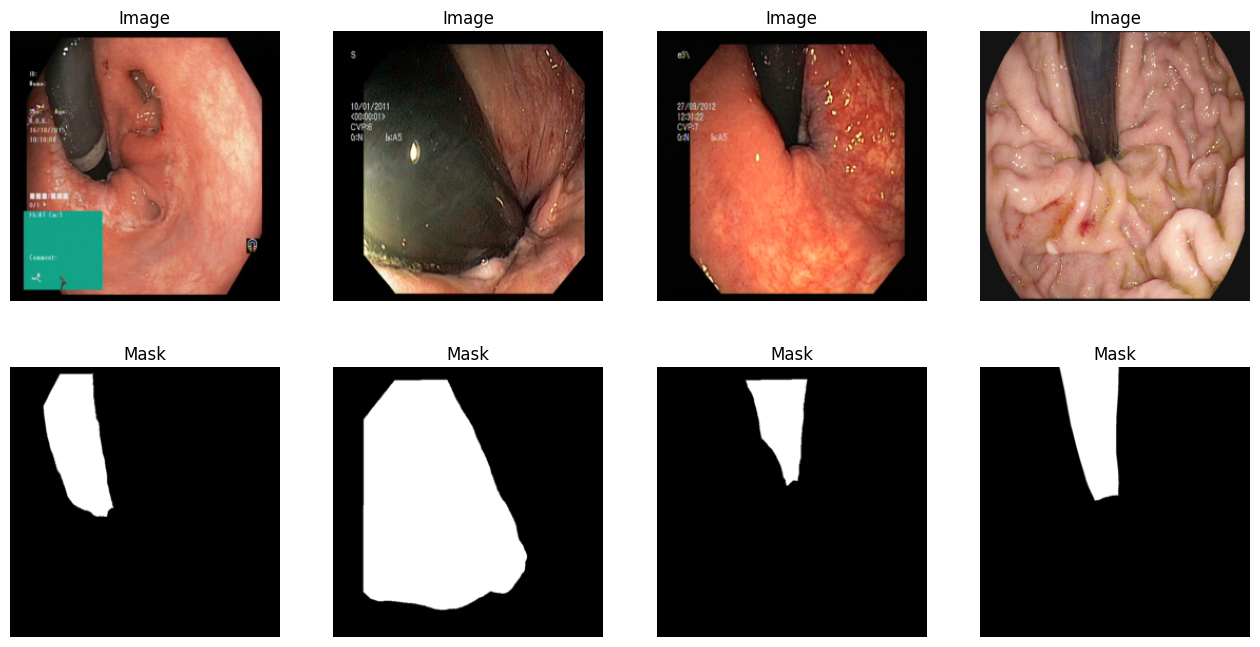

In [ ]:
def visualize_images_and_masks(dataloader):
    images, masks = next(iter(dataloader))

    fig, axs = plt.subplots(2, 4, figsize=(16, 8))

    for i in range(4):

        axs[0, i].imshow(images[i].permute(1, 2, 0))
        axs[0, i].set_title("Image")
        axs[0, i].axis('off')

        axs[1, i].imshow(masks[i].squeeze(), cmap='gray')
        axs[1, i].set_title("Mask")
        axs[1, i].axis('off')

    plt.show()

visualize_images_and_masks(dataloader)